<a href="https://colab.research.google.com/github/KoganTheDev/cloud-computing-project/blob/main/input_and_output_from_db.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install firebase

No existing indoor data to clear.
Uploaded indoor 1/20 at 18:51:19 with ID: -OR782AWItgoLTK9E3oe
Waiting 1 second(s) before next upload... (1/20)
Uploaded indoor 2/20 at 18:51:20 with ID: -OR782TBbrPIrZjDGmHe
Waiting 1 second(s) before next upload... (2/20)
Uploaded indoor 3/20 at 18:51:21 with ID: -OR782kim1BH2jsgq4wS
Waiting 1 second(s) before next upload... (3/20)
Uploaded indoor 4/20 at 18:51:22 with ID: -OR7832Be4UFbFIR_V3d
Waiting 1 second(s) before next upload... (4/20)
Uploaded indoor 5/20 at 18:51:24 with ID: -OR783KjeGJlXrp5mbUj
Waiting 1 second(s) before next upload... (5/20)
Uploaded indoor 6/20 at 18:51:25 with ID: -OR783cHBn9rzwuMurIX
Waiting 1 second(s) before next upload... (6/20)
Uploaded indoor 7/20 at 18:51:26 with ID: -OR783ui2QQjtCVHnE2F
Waiting 1 second(s) before next upload... (7/20)
Uploaded indoor 8/20 at 18:51:27 with ID: -OR784CGziQIjEWascDD
Waiting 1 second(s) before next upload... (8/20)
Uploaded indoor 9/20 at 18:51:28 with ID: -OR784UhPF0MrtsZatBI
Waiting

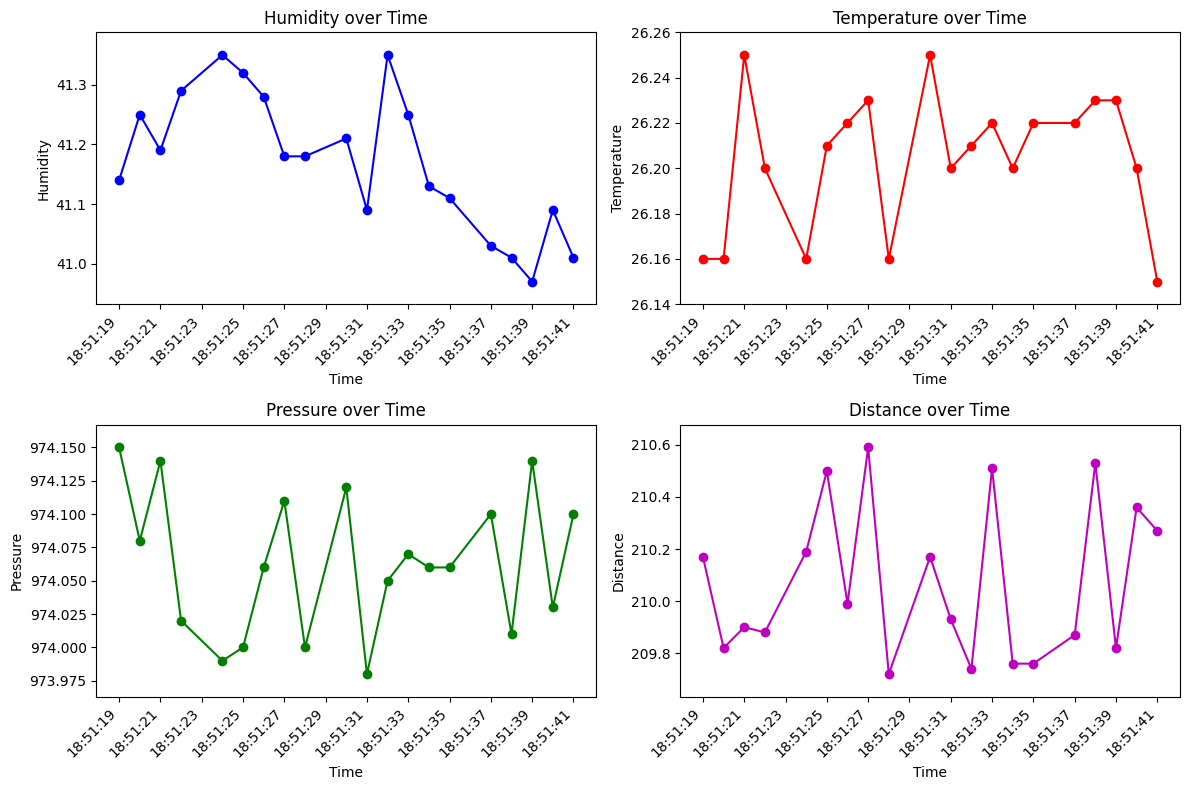

In [2]:
import time
from firebase import firebase
from datetime import datetime
from zoneinfo import ZoneInfo  # Python 3.9+
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import random

# Connect to Firebase
FBconn = firebase.FirebaseApplication(
    'https://cloudteamwolf-default-rtdb.europe-west1.firebasedatabase.app', None
)

local_tz = ZoneInfo("Asia/Jerusalem")

def generate_indoor_data_points(n=20):
    """Generate n logical indoor data points simulating slight fluctuations."""
    base_values = {
        "Humidity": 41.16,
        "Temperature": 26.2,
        "Pressure": 974.08,
        "Distance": 210.12
    }
    data_points = []
    for _ in range(n):
        point = {
            "Humidity": round(base_values["Humidity"] + random.uniform(-0.2, 0.2), 2),
            "Temperature": round(base_values["Temperature"] + random.uniform(-0.05, 0.05), 2),
            "Pressure": round(base_values["Pressure"] + random.uniform(-0.1, 0.1), 2),
            "Distance": round(base_values["Distance"] + random.uniform(-0.5, 0.5), 2),
        }
        data_points.append(point)
    return data_points

def clear_indoor_data_points():
    """Delete all data points under 'dataWarehouse/indoor'."""
    data = FBconn.get('dataWarehouse/indoor', None)
    if data:
        for key in data.keys():
            FBconn.delete('dataWarehouse/indoor', key)
        print("Cleared all existing indoor data points in 'dataWarehouse/indoor'.")
    else:
        print("No existing indoor data to clear.")

def add_indoor_data_points(data_points_raw, delay=1):
    """
    Add indoor data points to Firebase with a delay between each.
    Each data point gets a 'Time' field with local timestamp including milliseconds.
    Prints progress message every second.
    Returns list of uploaded keys.
    """
    uploaded_keys = []
    total = len(data_points_raw)
    for i, point in enumerate(data_points_raw, start=1):
        point_with_time = point.copy()
        point_with_time["Time"] = datetime.now(local_tz).strftime("%H:%M:%S")

        result = FBconn.post('dataWarehouse/indoor', point_with_time)
        uploaded_keys.append(result['name'])
        print(f"Uploaded indoor {i}/{total} at {point_with_time['Time']} with ID: {result['name']}")
        print(f"Waiting {delay} second(s) before next upload... ({i}/{total})")

        time.sleep(delay)
    return uploaded_keys

def get_indoor_data_points():
    """Retrieve all indoor data points from 'dataWarehouse/indoor'."""
    data = FBconn.get('dataWarehouse/indoor', None)
    print("Retrieved indoor data points:")
    print(data)
    return data

def plot_indoor_attributes_over_time(data):
    """
    Plot Humidity, Temperature, Pressure, and Distance over Time.
    data: dict from Firebase, keys are unique IDs, values are attribute dicts.
    """
    if not data:
        print("No indoor data to plot")
        return

    times, humidity, temperature, pressure, distance = [], [], [], [], []

    entries = []
    for val in data.values():
        time_obj = datetime.strptime(val['Time'], "%H:%M:%S")
        entries.append((time_obj, val))
    entries.sort(key=lambda x: x[0])

    for time_obj, val in entries:
        times.append(time_obj)
        humidity.append(val.get('Humidity'))
        temperature.append(val.get('Temperature'))
        pressure.append(val.get('Pressure'))
        distance.append(val.get('Distance'))

    def format_axis(ax, ydata, color, ylabel):
        ax.plot(times, ydata, marker='o', color=color)
        ax.set_title(f"{ylabel} over Time")
        ax.set_xlabel("Time")
        ax.set_ylabel(ylabel)
        # Format time axis to HH:MM:SS without microseconds for clarity
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        # Show ticks every 2 seconds (adjust as needed)
        ax.xaxis.set_major_locator(mdates.SecondLocator(interval=2))
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

        y_min = min(ydata) if ydata else 0
        y_max = max(ydata) if ydata else 1
        y_range = y_max - y_min if y_max != y_min else 1
        ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)

    plt.figure(figsize=(12, 8))
    format_axis(plt.subplot(2, 2, 1), humidity, 'b', 'Humidity')
    format_axis(plt.subplot(2, 2, 2), temperature, 'r', 'Temperature')
    format_axis(plt.subplot(2, 2, 3), pressure, 'g', 'Pressure')
    format_axis(plt.subplot(2, 2, 4), distance, 'm', 'Distance')
    plt.tight_layout()
    plt.show()

# Example usage:
clear_indoor_data_points()

data_points_raw = generate_indoor_data_points(20)
uploaded_keys = add_indoor_data_points(data_points_raw, delay=1)

all_data = get_indoor_data_points()
plot_indoor_attributes_over_time(all_data)


In [3]:
import time
from firebase import firebase
from datetime import datetime
from zoneinfo import ZoneInfo  # Python 3.9+
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import random

# Connect to Firebase
FBconn = firebase.FirebaseApplication(
    'https://cloudteamwolf-default-rtdb.europe-west1.firebasedatabase.app', None
)

local_tz = ZoneInfo("Asia/Jerusalem")

def generate_outdoor_data_points(n=20):
    """
    Generate n logical outdoor data points simulating slight fluctuations.
    Includes DLIGHT for outdoor light intensity (Lux).
    """
    data_points = []

    base_humidity = 35.0
    base_temperature = 18.0
    base_pressure = 973.0
    base_distance = 205.0
    base_dlight = 15000  # Lux

    for _ in range(n):
        humidity = base_humidity + random.uniform(-0.3, 0.3)
        temperature = base_temperature + random.uniform(-0.1, 0.1)
        pressure = base_pressure + random.uniform(-0.15, 0.15)
        distance = base_distance + random.uniform(-1, 1)
        dlight = base_dlight + random.uniform(-500, 500)

        point = {
            "Humidity": round(humidity, 2),
            "Temperature": round(temperature, 2),
            "Pressure": round(pressure, 2),
            "Distance": round(distance, 2),
            "DLIGHT": round(dlight, 2),
        }
        data_points.append(point)

    return data_points

def clear_outdoor_data_points():
    """
    Delete all data points under 'dataWarehouse/outdoor'
    """
    data = FBconn.get('dataWarehouse/outdoor', None)
    if data:
        for key in data.keys():
            FBconn.delete('dataWarehouse/outdoor', key)
        print("Cleared all existing outdoor data points in 'dataWarehouse/outdoor'.")
    else:
        print("No existing outdoor data to clear.")

def add_outdoor_data_points(data_points_raw, delay=1):
    """
    Add outdoor data points to Firebase with delay.
    Each point gets a 'Time' field with local timestamp including milliseconds.
    """
    uploaded_keys = []
    for i, point in enumerate(data_points_raw, start=1):
        point_with_time = point.copy()
        point_with_time["Time"] = datetime.now(local_tz).strftime("%H:%M:%S")

        result = FBconn.post('dataWarehouse/outdoor', point_with_time)
        uploaded_keys.append(result['name'])
        print(f"Uploaded outdoor {i}/{len(data_points_raw)} at {point_with_time['Time']} with ID: {result['name']}")

        print(f"Waiting 1 second before next outdoor upload... ({i})")
        time.sleep(delay)
    return uploaded_keys

def get_outdoor_data_points():
    """
    Retrieve all outdoor data points from 'dataWarehouse/outdoor'
    """
    data = FBconn.get('dataWarehouse/outdoor', None)
    print("Retrieved outdoor data points:")
    print(data)
    return data

def plot_outdoor_attributes_over_time(data):
    """
    Plot outdoor sensor attributes over time.
    """
    if not data:
        print("No outdoor data to plot")
        return

    times = []
    humidity = []
    temperature = []
    pressure = []
    distance = []
    dlight = []

    entries = []
    for key, val in data.items():
        time_obj = datetime.strptime(val['Time'], "%H:%M:%S")
        entries.append((time_obj, val))

    entries.sort(key=lambda x: x[0])

    for time_obj, val in entries:
        times.append(time_obj)
        humidity.append(val.get('Humidity'))
        temperature.append(val.get('Temperature'))
        pressure.append(val.get('Pressure'))
        distance.append(val.get('Distance'))
        dlight.append(val.get('DLIGHT'))

    def format_axis(ax, ydata, color, ylabel):
        ax.plot(times, ydata, marker='o', color=color)
        ax.set_title(f"{ylabel} over Time")
        ax.set_xlabel("Time")
        ax.set_ylabel(ylabel)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

        y_min = min(ydata) if ydata else 0
        y_max = max(ydata) if ydata else 1
        y_range = y_max - y_min if y_max != y_min else 1
        ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)

    plt.figure(figsize=(14, 10))

    ax1 = plt.subplot(3, 2, 1)
    format_axis(ax1, humidity, 'b', 'Humidity')

    ax2 = plt.subplot(3, 2, 2)
    format_axis(ax2, temperature, 'r', 'Temperature')

    ax3 = plt.subplot(3, 2, 3)
    format_axis(ax3, pressure, 'g', 'Pressure')

    ax4 = plt.subplot(3, 2, 4)
    format_axis(ax4, distance, 'm', 'Distance')

    ax5 = plt.subplot(3, 2, 5)
    format_axis(ax5, dlight, 'orange', 'DLIGHT (Lux)')

    plt.tight_layout()
    plt.show()

# Usage example:

clear_outdoor_data_points()

data_points_raw = generate_outdoor_data_points(20)
uploaded_keys = add_outdoor_data_points(data_points_raw, delay=1)

all_data = get_outdoor_data_points()
plot_outdoor_attributes_over_time(all_data)


No existing outdoor data to clear.
Uploaded outdoor 1/20 at 18:51:44 with ID: -OR788HWzyGsBklBVLzo
Waiting 1 second before next outdoor upload... (1)
Uploaded outdoor 2/20 at 18:51:45 with ID: -OR788ZwvY18bZx4uSyF
Waiting 1 second before next outdoor upload... (2)
Uploaded outdoor 3/20 at 18:51:46 with ID: -OR788rVQDgwhXgtxK6I
Waiting 1 second before next outdoor upload... (3)
Uploaded outdoor 4/20 at 18:51:47 with ID: -OR7898xjmbuvAKtc6jm
Waiting 1 second before next outdoor upload... (4)
Uploaded outdoor 5/20 at 18:51:49 with ID: -OR789RfzpJANpTtlAoo
Waiting 1 second before next outdoor upload... (5)
Uploaded outdoor 6/20 at 18:51:50 with ID: -OR789j9XRwKlpEvtLCz
Waiting 1 second before next outdoor upload... (6)
Uploaded outdoor 7/20 at 18:51:51 with ID: -OR78A0gRAIcDMWVUnEt
Waiting 1 second before next outdoor upload... (7)
Uploaded outdoor 8/20 at 18:51:52 with ID: -OR78AJ4ukvj33LmKIgu
Waiting 1 second before next outdoor upload... (8)
Uploaded outdoor 9/20 at 18:51:53 with ID: -O

KeyboardInterrupt: 

In [12]:
# Install dependencies (only needed in Jupyter or Colab)
!pip install requests beautifulsoup4 nltk firebase

# Import modules
import requests
from bs4 import BeautifulSoup
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
from firebase import firebase

# Download stopwords
nltk.download('stopwords')
english_stop_words = set(stopwords.words('english'))

# Firebase setup
firebase_url = "https://cloudteamwolf-default-rtdb.europe-west1.firebasedatabase.app"
FBconn = firebase.FirebaseApplication(firebase_url, None)

# Pages to index
seed_urls = {
    1: 'https://mqtt.org/',
    2: 'https://mqtt.org/documentation',
    3: 'https://mqtt.org/software',
    4: 'https://mqtt.org/getting-started/',
    5: 'https://mqtt.org/mqtt-specification/',
    6: 'https://mqtt.org/use-cases/',
    7: 'https://mqtt.org/faq/',
}

# Fetch page content
def fetch_page_text(url):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            return soup.get_text()
    except Exception as e:
        print(f"Failed to fetch {url}: {e}")
    return ""

# Sanitize Firebase key (no dots, $, #, [, ] allowed)
def sanitize_key(key: str) -> str:
    return re.sub(r'[.#$\[\]]', '_', key)

# Build full index using URLs as "DocIDs"
def build_index(urls):
    index = {}
    stemmer = PorterStemmer()

    for _, url in urls.items():
        print(f"Fetching and processing {url} ...")
        text = fetch_page_text(url)
        words = re.findall(r'\w+', text.lower())

        for word in words:
            if word in english_stop_words or len(word) <= 2:
                continue
            stemmed = stemmer.stem(word)
            if stemmed not in index:
                index[stemmed] = {
                    "term": stemmed,
                    "DocIDs": {},
                    "count": 0
                }
            # Count occurrences per URL
            index[stemmed]["DocIDs"][url] = index[stemmed]["DocIDs"].get(url, 0) + 1
            index[stemmed]["count"] += 1

    # Convert DocIDs dict to sorted list of URLs + counts
    for data in index.values():
        data["DocIDs"] = [
            {"url": url, "count": count}
            for url, count in sorted(data["DocIDs"].items())
        ]

    return index

# Build and sort index
full_index = build_index(seed_urls)

# Get top 100 terms by frequency
top_100_terms = sorted(full_index.values(), key=lambda x: x["count"], reverse=True)[:100]

# Prepare upload dict with sanitized keys for Firebase compatibility
top_100_index = {
    sanitize_key(entry["term"]): {
        "term": entry["term"],
        "count": entry["count"],
        "DocIDs": entry["DocIDs"]
    }
    for entry in top_100_terms
}

# Upload to Firebase under dataWarehouse/Index
print("\nUploading Top 100 words to Firebase...")
FBconn.put('/dataWarehouse', 'Index', top_100_index)
print("Upload complete.")

# Display results
print("\nTop 100 words uploaded:")
for entry in top_100_terms:
    print(f"{entry['term']:15} → {entry['count']:4} total occurrences in:")
    for site in entry["DocIDs"]:
        print(f"  {site['url']} → {site['count']} times")



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fetching and processing https://mqtt.org/ ...
Fetching and processing https://mqtt.org/documentation ...
Fetching and processing https://mqtt.org/software ...
Fetching and processing https://mqtt.org/getting-started/ ...
Fetching and processing https://mqtt.org/mqtt-specification/ ...
Fetching and processing https://mqtt.org/use-cases/ ...
Fetching and processing https://mqtt.org/faq/ ...

Uploading Top 100 words to Firebase...
Upload complete.

Top 100 words uploaded:
mqtt            →  358 total occurrences in:
  https://mqtt.org/ → 19 times
  https://mqtt.org/faq/ → 17 times
  https://mqtt.org/getting-started/ → 10 times
  https://mqtt.org/mqtt-specification/ → 19 times
  https://mqtt.org/software → 285 times
  https://mqtt.org/use-cases/ → 8 times
client          →   89 total occurrences in:
  https://mqtt.org/ → 3 times
  https://mqtt.org/software → 86 times
broker          →   81 total occurrences in:
  https://mqtt.org/ → 1 times
  https://mqtt.org/faq/ → 4 times
  https://mqtt.